# <span style="font-family:Optima; font-size:2em;">OAI clinical data processing</span>
Key updates:
* Variables such as "left hip pain" have been transformed to be ipsilateral and contralateral pain. This is really important, otherwise their effects are canceled out by having left and right knees.
* Certain variables such as Hip Fracture are added
* Some variables removed, e.g. "Maritial Status = Separated"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import xarray

In [3]:
pd.set_option('mode.chained_assignment', 'raise')

In [4]:
oai_raw = pd.read_csv("data/OAI_v1.1.csv", low_memory=False)
oai = oai_raw.copy()

In [5]:
oai.shape

(9592, 116)

# Metadata

I created a metadata file that has some extra information about each variable. We load this here.

In [4]:
data_dict = pd.read_excel("data/OAI_data_dict.xlsx").set_index("name")
data_dict.head()

,column_number,parent,var_type,short_label,long_label,format
name,,,,,,
ID,1,NaN,numeric,Patient ID,ReleaseID,$
P02HISP,2,NaN,binary,Is Hispanic,"IEI:Q3.Hispanic or Latino, self-reported",YNDK
P02RACE,3,NaN,categoric,Race,"IEI:Racial background, self-reported (calc)",RACECAT
P02SEX,4,NaN,binary,Sex,"IEI:Q2.Gender, male or female",GENDER
V00COHORT,5,NaN,categoric,Cohort,EV:Subcohort assignment (calc),COHORT


In [5]:
def add_meta(name, parent, var_type, short_label=None, long_label=None, column_number=None, format_=None):
    data_dict.loc[name] = {'column_number': column_number,
                           'parent': parent,
                           'short_label': short_label or name,
                           'long_label': long_label or short_label or name,
                           'var_type': var_type,
                           'format': format_}
    

## Shorten the missing codes
Anything that starts with a `.` is a missing. We verify this:

In [6]:
def find_values_that_start_with_dot(x):
    if type(x) is not str:
        return False
    
    elif (x[0] == '.'):
        # if the first character is a ., then the second char will be the missing code.
        return True
    
    else:
        return False
    
flat_oai = pd.Series(oai.values.flatten())

flat_oai[flat_oai.map(find_values_that_start_with_dot)].value_counts()

.A: Not Expected                    92528
.E: Non-Exposed Control              1820
.D: Don t Know/Unknown/Uncertain     1275
.R: Refused                           970
.M: Missing                           944
.O: Not done, other reason            104
.W: Impossible value                    9
dtype: int64

Having verified that, we can map all of these to their first letter.

In [7]:
def map_missing_codes(x):
    # if x is not a string, i.e. some kind
    # of number, then it's not a SAS missing
    if type(x) is not str:
        return x
    
    elif (x[0] == '.'):
        # if the first character is a ., then the second char will be the missing code.
        return x[1]
    
    else:
        return x

In [8]:
oai = oai.applymap(map_missing_codes)

# Non-exposed control cohort
* 244 knees in this cohort
* 75% of them did not have the knee exam done, 25% did.
* There doesn't seem to be a reason to treat these people differently, so we're going to keep any of these knees that aren't missing any values.

In [9]:
oai['V00COHORT'].value_counts()

2: Incidence                    6568
1: Progression                  2780
3: Non-exposed control group     244
Name: V00COHORT, dtype: int64

In [10]:
# Find columns and rows that contain the .E missing code
Ecols  = (oai == "E").any(axis=0)
Eknees = (oai == "E").any(axis=1)

Who are these knees?

In [11]:
oai.loc[Eknees, :].head()

,ID,P02HISP,P02RACE,P02SEX,V00COHORT,V99EXIOA,side,P01KPN12,P01HPNR12,P01HPNRIL,...,V00PASE,V00RX30NUM_modified,V00MARITST_modified,V00EDCV_modified,WHITE,P01MEN_modified,P01MENINJ_modified,P01ART_modified,P01ARTINJ_modified,P01LR_modified
1820,9222048,0: No,1: White or Caucasian,2: Female,3: Non-exposed control group,"2: KL0-1 at BL, follow-up x-rays but no incide...",1,0: No,0: No,A,...,257,0,1,1,1,0,0,0,0,0
1821,9222048,0: No,1: White or Caucasian,2: Female,3: Non-exposed control group,"2: KL0-1 at BL, follow-up x-rays but no incide...",2,0: No,0: No,A,...,257,0,1,1,1,0,0,0,0,0
1832,9223040,0: No,1: White or Caucasian,2: Female,3: Non-exposed control group,"2: KL0-1 at BL, follow-up x-rays but no incide...",1,0: No,0: No,A,...,167,3,1,1,1,0,0,0,0,0
1833,9223040,0: No,1: White or Caucasian,2: Female,3: Non-exposed control group,"2: KL0-1 at BL, follow-up x-rays but no incide...",2,0: No,0: No,A,...,167,3,1,1,1,0,0,0,0,0
1842,9223685,0: No,1: White or Caucasian,1: Male,3: Non-exposed control group,"2: KL0-1 at BL, follow-up x-rays but no incide...",1,0: No,0: No,A,...,265,1,1,1,1,0,0,0,0,0


We see that all the knees that take the E value are in the "Non-exposed control group"

In [12]:
oai.loc[Eknees, 'V00COHORT'].value_counts()

3: Non-exposed control group    182
Name: V00COHORT, dtype: int64

But not every knee in the "Non-exposed control group" takes the E value. Here are the value counts for knees in the "Non-exposed control group" across the relevant variables:

In [13]:
oai.loc[oai['V00COHORT']=="3: Non-exposed control group", Ecols].apply(lambda s: s.value_counts())

,V00KPATPN,V00KEFFB,V00KEFFPT,V00KRFXPN,V00KLTTPN,V00KMTTPN,V00KABPN,V00KPFCRE,V00KPGDPN,V00KFHDEG,V00KALNMT,V00kdefcv
-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,NaN
-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,4.0,NaN
-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,3.0,NaN
-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN
-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,NaN
-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,24.0,NaN
0: Neither,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
0: No,60.0,59.0,57.0,62.0,61.0,61.0,59.0,53.0,59.0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN


This indicates that 182 knees from this cohort did not have the knee exam done, while 62 did. Since there doesn't seem to be a good reason to exclude people in this cohort, we will only drop the knees that had the E values.

# Redundant and uninformative variables

* `V00kdefcv` "EV: knee exam: alignment varus or valgus" is a child of `V00KALNMT`, which says the actual alignment in degrees
* `WHITE` is a child of `P02RACE`
* `V00EDCV_modified` is an indicator of whether `V00EDCV` (education level) is "Some college" or higher
* `V00RXFLUOR`, `V00RXMSM`, `V00RXSAME`: these are medications no one reported using, although some did not report (missing)
* `V00WOMTS` "WOMAC Total" is the sum of the other WOMACs.
* `V00COHORT`: Each patient's eligibility for the OAI study was determined by onsite measurements at one of four sites. These measurements determined the value of `V00COHORT`, which could be Progression, Incidence, and Non-Exposed Control. We're interested in the whole group, not broken out by this cohort identification.
* `V99EXIOA`: this is a non-baseline variable.
* `V00RXVLCXB`, `V00RXCLCTN`, `V00RXBISPH`, `V00RXIHYAL`, `V00RXRFCXB`, `V00RXCHOND`, `V00RXOTHAN`, `V00RXGLCSM`, `V00RXACTM`, `V00RXASPRN`, `V00RXNTRAT`, `V00RXRALOX`, `V00RXVIT_D`, `V00RXOSTRD`, `V00RXCLCXB`, `V00RXTPRTD`, `V00RXSALIC`: Dr. Nelson says we can drop these.

In [14]:
oai = oai.drop(['V00COHORT', 'V00kdefcv', 'WHITE', 'V00EDCV_modified', 
                'V00RXFLUOR', 'V00RXMSM', 'V00RXSAME', 'V00WOMTS', 'V99EXIOA'], axis=1)

In [15]:
oai = oai.drop(['V00RXVLCXB','V00RXCLCTN','V00RXBISPH','V00RXIHYAL','V00RXRFCXB','V00RXCHOND','V00RXOTHAN',
                'V00RXGLCSM','V00RXACTM','V00RXASPRN','V00RXNTRAT','V00RXRALOX','V00RXVIT_D','V00RXOSTRD',
                'V00RXCLCXB','V00RXTPRTD','V00RXSALIC',], axis=1)

### <mark>Some modified variables--what is this?</mark>

In [16]:
oai = oai.drop(['V00RX30NUM'], axis=1)

oai = oai.drop(['P01ARTINJ', 'P01ART', 'P01LR', 'P01MENINJ', 'P01MEN'], axis=1)

oai = oai.rename({'P01ARTINJ_modified': 'P01ARTINJ',
'P01ART_modified': 'P01ART',
'P01LR_modified': 'P01LR',
'P01MENINJ_modified': 'P01MENINJ',
'P01MEN_modified': 'P01MEN',
'V00RX30NUM_modified': 'V00RX30NUM'}, axis=1)

# Unusual variables

### `side`
Downstream analyses are easier if side is written as left/right instead of 1 and 2.

In [17]:
oai['side'] = oai['side'].map({1: 'right', 2: 'left'})

### `V00INCOME2`

In [18]:
oai['V00INCOME2'].value_counts()

2: > $50K    5590
1: < $50K    3552
D             274
R             140
M              36
Name: V00INCOME2, dtype: int64

In [19]:
oai['LowIncome'] = oai['V00INCOME2'].map({"2: > $50K": 0, "1: < $50K": 1})
oai = oai.drop(['V00INCOME2'], axis=1)
add_meta('LowIncome', parent='V00INCOME2', var_type='binary', short_label='Income < 50K')

In [20]:
oai['LowIncome'].value_counts()

0.0    5590
1.0    3552
Name: LowIncome, dtype: int64

In [21]:
incomes = oai_raw['V00INCOME2'].value_counts()

In [22]:
incomes

2: > $50K                           5590
1: < $50K                           3552
.D: Don t Know/Unknown/Uncertain     274
.R: Refused                          140
.M: Missing                           36
Name: V00INCOME2, dtype: int64

In [23]:
incomes.index[1]

'1: < $50K'

### `P02RACE`

In [24]:
oai['P02RACE'].value_counts()

1: White or Caucasian           7580
2: Black or African American    1748
0: Other Non-white               164
3: Asian                          90
D                                  6
R                                  4
Name: P02RACE, dtype: int64

In [25]:
oai['Other race'] = oai['P02RACE'].map({"0: Other Non-white": 1,
                                        "1: White or Caucasian": 0,
                                        "2: Black or African American": 0,
                                        "3: Asian": 0})
oai['White race'] = oai['P02RACE'].map({"0: Other Non-white": 0,
                                        "1: White or Caucasian": 1,
                                        "2: Black or African American": 0,
                                        "3: Asian": 0})
oai['Black race'] = oai['P02RACE'].map({"0: Other Non-white": 0,
                                        "1: White or Caucasian": 0,
                                        "2: Black or African American": 1,
                                        "3: Asian": 0})
oai['Asian race'] = oai['P02RACE'].map({"0: Other Non-white": 0,
                                        "1: White or Caucasian": 0,
                                        "2: Black or African American": 0,
                                        "3: Asian": 1})
oai = oai.drop('P02RACE', axis=1)

add_meta('Other race', parent='P02RACE', var_type='binary', 
         long_label='Racial background, self-reported (calc): Other Non-white')
add_meta('White race', parent='P02RACE', var_type='binary', 
         long_label='Racial background, self-reported (calc): White or Caucasian')
add_meta('Black race', parent='P02RACE', var_type='binary', 
         long_label='Racial background, self-reported (calc): Black or African-American')
add_meta('Asian race', parent='P02RACE', var_type='binary', 
         long_label='Racial background, self-reported (calc): Asian')

### `V00MARITST` and `V00MARITST_modified`
These variables refer to marital status. The `_modified` one is just an indicator for Married. We will use this one, and map the Refused and Missing to nan.

In [26]:
oai['V00MARITST'].value_counts()

1: Married          6356
3: Divorced         1358
5: Never married     856
2: Widowed           768
4: Separated         172
R                     74
M                      8
Name: V00MARITST, dtype: int64

In [27]:
oai['V00MARITST_modified'].value_counts()

1    6356
0    3154
R      74
M       8
Name: V00MARITST_modified, dtype: int64

In [28]:
data_dict.head()

,column_number,parent,var_type,short_label,long_label,format
name,,,,,,
ID,1,NaN,numeric,Patient ID,ReleaseID,$
P02HISP,2,NaN,binary,Is Hispanic,"IEI:Q3.Hispanic or Latino, self-reported",YNDK
P02RACE,3,NaN,categoric,Race,"IEI:Racial background, self-reported (calc)",RACECAT
P02SEX,4,NaN,binary,Sex,"IEI:Q2.Gender, male or female",GENDER
V00COHORT,5,NaN,categoric,Cohort,EV:Subcohort assignment (calc),COHORT


In [29]:
oai['Is Married'] = pd.to_numeric(oai['V00MARITST_modified'], errors='coerce')
oai = oai.drop(['V00MARITST_modified', 'V00MARITST'], axis=1)
add_meta('Is Married', parent='V00MARITST', var_type='binary', short_label="Currently married")

### `V00CEMPLOY` and `V00CUREMP`
These say the employment status as well as a derived binary corresponding to level `1: Works for pay`.
We will use the binary one, and map the two "D: Don't know" to 0.

In [30]:
oai.groupby('V00CUREMP')[['V00CEMPLOY','V00CUREMP']].value_counts().to_frame()

0
V00CUREMP V00CEMPLOY                                
0: No     4: Not working other reasons          3058
          3: Not working in part due to health   488
          2: Unpaid work for family business     108
          D                                       34
          M                                       12
1: Yes    1: Works for pay                      5886
D         3: Not working in part due to health     2
          4: Not working other reasons             2
R         R                                        2

In [31]:
oai = oai.drop('V00CEMPLOY', axis=1)

### `P02SEX`

In [32]:
oai['P02SEX'].value_counts()

2: Female    5608
1: Male      3984
Name: P02SEX, dtype: int64

In [33]:
oai['Female Sex'] = oai['P02SEX'].map({'2: Female': 1, '1: Male': 0})
oai = oai.drop('P02SEX', axis=1)

In [34]:
add_meta('Female Sex', parent='P02SEX', var_type='binary')

### `V00HIPFX`
This variable refers to a subquestion of `V00BONEFX`. People who answered that they had a bone fracture received a subquestion on whether they'd had a hip fracture. For people with no bone fracture, they did not receive this subquestion, so they are listed as `A: Not Expected`. Therefore we code them as 0, i.e. no hip fracture.

In [35]:
oai.groupby('V00BONEFX')['V00HIPFX'].value_counts().to_frame()

V00HIPFX
V00BONEFX V00HIPFX          
0: No     A             7794
          0: No            2
1: Yes    0: No         1582
          1: Yes         100
          M                2
D         A               36
M         A                8
R         R               68

In [36]:
oai['V00HIPFX'] = oai['V00HIPFX'].map({'A': 0, '0: No': 0, '1: Yes': 1})

### `P01HRSR` and `P01HRSL`
These variables refer to subquestions of `P01HRS`. People who answered that they'd had a hip replacement were asked which side it was on. While very few people in the study had had a hip replacement, among those that had, there were similar numbers for left only, right only, and both sides:

In [37]:
oai.groupby('P01HRS')[['P01HRSR','P01HRSL']].value_counts().to_frame()

0
P01HRS P01HRSR P01HRSL      
0: No  A       A        9450
1: Yes 1: Yes  0: No      56
               1: Yes     46
       0: No   1: Yes     38
D      A       A           2

We recode these as:
* Hip replacement same side
* Hip replacement opposite side
People who have had double HRS will have ones in both columns.

In [38]:
# The two knees with ".D" for P01HRS get sent to NaN here.
oai['P01HRS'] = oai['P01HRS'].map({'0: No': 0, '1: Yes': 1})

In [39]:
oai['P01HRSR'] = oai['P01HRSR'].map({'A': 0, '0: No': 0, '1: Yes': 1}) * oai['P01HRS']
oai['P01HRSL'] = oai['P01HRSL'].map({'A': 0, '0: No': 0, '1: Yes': 1}) * oai['P01HRS']

In [40]:
oai.groupby('P01HRS')[['P01HRSR','P01HRSL']].value_counts().to_frame()

0
P01HRS P01HRSR P01HRSL      
0.0    0.0     0.0      9450
1.0    1.0     0.0        56
               1.0        46
       0.0     1.0        38

Looks good so far.

In [41]:
# The reason to multiply by P01HRS at the end is so that those two knees with ".D" in P01HRS get sent to NaN.
oai['SameSideHRS'] = (oai['side'].map({'right': 1, 'left': 0}) * oai['P01HRSR'] + 
                      oai['side'].map({'right': 0, 'left': 1}) * oai['P01HRSL'])

oai['OppositeHRS'] = (oai['side'].map({'right': 1, 'left': 0}) * oai['P01HRSL'] + 
                      oai['side'].map({'right': 0, 'left': 1}) * oai['P01HRSR'])
oai['BothHRS'] = oai['SameSideHRS'] * oai['OppositeHRS']

add_meta('SameSideHRS', parent="P01HRS, P01HRSL, P01HRSR", var_type='binary', 
         short_label="Ipsil. HRS", long_label="Ipsilateral hip replacement surgery")
add_meta('OppositeHRS', parent="P01HRS, P01HRSL, P01HRSR", var_type='binary', 
         short_label="Contral. HRS", long_label="Contralateral hip replacement surgery")
add_meta('BothHRS', parent="P01HRS, P01HRSL, P01HRSR", var_type='binary', 
         short_label="Double HRS", long_label="Both sides hip replacement surgery")

In [42]:
oai[['SameSideHRS', 'OppositeHRS']].value_counts().to_frame()

0
SameSideHRS OppositeHRS      
0.0         0.0          9450
            1.0            47
1.0         0.0            47
            1.0            46

In [43]:
oai = oai.drop(['P01HRS', 'P01HRSR', 'P01HRSL'], axis=1)

### `P01HPNR12` and `P01HPNL12`
These variables refer to right/left hip pain in last 12 months. We recode to Same Side and Opposite Side like above.

In [44]:
oai['P01HPNR12'].value_counts()

0: No     5392
1: Yes    4176
D           24
Name: P01HPNR12, dtype: int64

In [45]:
oai['P01HPNL12'].value_counts()

0: No     5838
1: Yes    3726
D           28
Name: P01HPNL12, dtype: int64

In [46]:
oai[['P01HPNL12','P01HPNR12']].value_counts().to_frame()

0
P01HPNL12 P01HPNR12      
0: No     0: No      4254
1: Yes    1: Yes     2590
0: No     1: Yes     1580
1: Yes    0: No      1132
D         D            16
          0: No         6
          1: Yes        6
0: No     D             4
1: Yes    D             4

In [47]:
oai['P01HPNR12'] = oai['P01HPNR12'].map({'0: No': 0, '1: Yes': 1})
oai['P01HPNL12'] = oai['P01HPNL12'].map({'0: No': 0, '1: Yes': 1})

In [48]:
data_dict.loc['P01HPNR12','long_label']

'SV:Q38.Right hip pain, aching or stiffness: any, past 12 months (includes pain in groin and in front and sides of upper thigh)'

In [49]:
oai['SameSideHP12'] = (oai['side'].map({'right': 1, 'left': 0}) * oai['P01HPNR12'] + 
                      oai['side'].map({'right': 0, 'left': 1}) * oai['P01HPNL12'])

oai['OppositeHP12'] = (oai['side'].map({'right': 1, 'left': 0}) * oai['P01HPNL12'] + 
                      oai['side'].map({'right': 0, 'left': 1}) * oai['P01HPNR12'])

oai['BothHP12'] = oai['SameSideHP12'] * oai['OppositeHP12']

add_meta('SameSideHP12', parent='P01HPNR12, P01HPNL12', var_type='binary',
        short_label="Ipsil. hip pain last 12 mo",
        long_label="Ipsilateral hip pain, aching, or stiffness: any, past 12 months")
add_meta('OppositeHP12', parent='P01HPNR12, P01HPNL12', var_type='binary',
        short_label="Contral. hip pain last 12 mo",
        long_label="Contralateral hip pain, aching, or stiffness: any, past 12 months")
add_meta('BothHP12', parent='P01HPNR12, P01HPNL12', var_type='binary',
        short_label="Pain both hips last 12 mo",
        long_label="Both hips - pain, aching, or stiffness: any, past 12 months")

In [50]:
oai = oai.drop(['P01HPNR12','P01HPNL12'], axis=1)

### `P01HPNLIL` and `P01HPNRIL`
These variables refer to subquestions for people who answered that they had hip pain in the last 12 months (`P01HPNR12` or `P01HPNL12`). The subquestion asked if the hip pain was in the groin area. Everyone who was asked this subquestion said yes, so there is no variation. Therefore we can just drop these.

In [51]:
oai['P01HPNLIL'].value_counts()

A                               9336
1: Groin/Inside leg near hip     256
Name: P01HPNLIL, dtype: int64

In [52]:
oai['P01HPNRIL'].value_counts()

A                               9310
1: Groin/Inside leg near hip     282
Name: P01HPNRIL, dtype: int64

In [53]:
oai = oai.drop(['P01HPNLIL', 'P01HPNRIL'], axis=1)

## `V00RX30` and `V00RX30NUM`

In [54]:
oai['V00RX30'].value_counts()

1: All          7712
3: Took None    1820
0: No             42
2: Some           18
Name: V00RX30, dtype: int64

In [55]:
oai['V00RX30NUM'].isna().sum()

0

In [56]:
oai['V00RX30NUM'].value_counts()

0     1820
2     1562
1     1550
3     1298
4     1096
5      720
6      510
7      348
8      238
9      204
10      80
A       42
12      34
13      26
11      24
14      14
16      10
15      10
27       2
18       2
19       2
Name: V00RX30NUM, dtype: int64

In [57]:
oai.loc[oai['V00RX30']=='2: Some', 'V00RX30NUM']

16      6
17      6
318     3
319     3
600     7
601     7
874     2
875     2
5486    5
5487    5
6966    3
6967    3
7992    5
7993    5
8182    4
8183    4
8586    1
8587    1
Name: V00RX30NUM, dtype: object

It makes sense that people who did not identify any of their meds are given a NaN for number of meds they take. But what is this number for people who identified only some of their meds?
For now I leave as is and drop the `V00RX30` column.

In [58]:
oai = oai.drop('V00RX30', axis=1)

In [59]:
pd.set_option('display.max_columns', None)

In [60]:
oai.head()

,ID,P02HISP,side,P01KPN12,P01BP30,P01HPR12CV,P01HPL12CV,V00HSPSS,V00HSMSS,V00WOMKP,V00KOOSKP,V00WOMSTF,V00KOOSYM,V00WOMADL,P01KSX,P01INJ,P01KSURG,V00BONEFX,V00HIPFX,V00SPNFX,V00FALL,V00SMOKE,V00DRNKAMT,V00DRKMORE,V00COMORB,V00CESD,V00RXANALG,V00RXNARC,V00RXISTRD,V00RXCOX2,V00RXNSAID,V00BPSYS,V00BPDIAS,V00CSTSGL,V00KPATPN,V00KEFFB,V00KEFFPT,V00KRFXPN,V00KLTTPN,V00KMTTPN,V00KABPN,V00KPFCRE,V00KPGDPN,V00LWGT,P01BMI,V00CS5,V00CSPACE,V00EXP1CV,V00FXP1CV,V0020MPACE,V00KFHDEG,V00KALNMT,V00fmaxf,V00400MTIM,V00fSFR,V00eSFP,V00eSFR,V00fSFP,P02FAMHXKR,V00AGE,V00CUREMP,V00EDCV,V00MEDINS,V00PASE,V00RX30NUM,P01MEN,P01MENINJ,P01ART,P01ARTINJ,P01LR,LowIncome,Other race,White race,Black race,Asian race,Is Married,Female Sex,SameSideHRS,OppositeHRS,BothHRS,SameSideHP12,OppositeHP12,BothHP12
0,9000099,0: No,right,1: Yes,1: Yes,0: No,0: No,52.50,59.60,1.0,77.8,3.0,67.9,10.0,2: Pain most days of a month in past 12m,0: No,0: No,1: Yes,0.0,0: No,0: No,0: No,4: 8-14 drinks/week,1: Yes,0,1,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,124,60,"4: Not attempted, unable",0: No,0: No,0: No,1: Yes,0: No,0: No,0: No,1: Yes,0: No,23,23.8,0: No,A,1: Mild,0: None,1.328,10,3,160.5,309.03,437.7,86.4,1243.6,63.4,0: No,59,1: Yes,5: Graduate degree,1: Yes,132,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,9000099,0: No,left,1: Yes,1: Yes,0: No,0: No,52.50,59.60,0.0,100.0,0.0,100.0,0.0,2: Pain most days of a month in past 12m,1: Yes,1: Yes,1: Yes,0.0,0: No,0: No,0: No,4: 8-14 drinks/week,1: Yes,0,1,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,124,60,"4: Not attempted, unable",0: No,0: No,0: No,0: No,0: No,0: No,0: No,1: Yes,0: No,22,23.8,0: No,A,0: None,0: None,1.328,8,-4,140.9,309.03,704.5,362.3,1425.2,31,0: No,59,1: Yes,5: Graduate degree,1: Yes,132,0,1,1,1,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,9000296,0: No,right,0: No,0: No,1: Yes,0: No,56.15,57.16,0.0,100.0,0.0,100.0,0.0,0: No pain in past 12m,0: No,0: No,0: No,0.0,0: No,0: No,1: Yes,2: 1-3 drinks/week,1: Yes,0,2,1: Used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,1: Used in last 30 days,0: Not used in last 30 days,152,84,1: Stands without using arms,0: No,0: No,0: No,0: No,0: No,0: No,0: No,0: No,0: No,18,29.8,1: Yes,0.48,0: None,0: None,1.366,3,0,197.5,313.71,103,611.4,280.5,359.1,0: No,69,1: Yes,2: Some college,1: Yes,190,3,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0
3,9000296,0: No,left,0: No,0: No,1: Yes,0: No,56.15,57.16,0.0,100.0,0.0,100.0,0.0,0: No pain in past 12m,1: Yes,1: Yes,0: No,0.0,0: No,0: No,1: Yes,2: 1-3 drinks/week,1: Yes,0,2,1: Used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,1: Used in last 30 days,0: Not used in last 30 days,152,84,1: Stands without using arms,0: No,0: No,0: No,0: No,0: No,0: No,0: No,0: No,0: No,12,29.8,1: Yes,0.48,0: None,0: None,1.366,3,-2,225.6,313.71,966.9,322.1,563.7,270.7,0: No,69,1: Yes,2: Some college,1: Yes,190,3,1,1,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0
4,9000622,0: No,right,1: Yes,1: Yes,1: Yes,0: No,33.23,65.54,3.0,75.0,3.0,82.1,14.9,2: Pain most days of a month in past 12m,0: No,0: No,1: Yes,0.0,1: Yes,1: Yes,1: Yes,2: 1-3 drinks/week,0: No,1,4,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,136,60,1: Stands without using arms,0: No,0: No,0: No,1: Yes,0: No,0: No,0: No,0: No,0: No,14,22.7,1: Yes,0.6,0: None,0: None,1.431,0,3,75.6,295.91,453.6,497.3,113.5,19,0: No,71,0: No,1: High school graduate,0: No,157,8,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,1,0.0,0.0,0.0,1.0,0.0,0.0


# Ordinal variables

In [61]:
data_dict[data_dict['var_type']=='ordinal']

,column_number,parent,var_type,short_label,long_label,format
name,,,,,,
V99EXIOA,6,NaN,ordinal,Knee KL score,"Outcomes: knee, summary incident TF ROA KL >=...",EXK
P01KSX,24,NaN,ordinal,Knee baseline symptom status,SV: knee baseline symptom status (combines pas...,KPNFR
V00DRNKAMT,40,NaN,ordinal,Num drinks/week,SAQ:Q41.How many alcoholic drinks in typical w...,ALCOHOLA
V00CSTSGL,73,NaN,ordinal,Single chair stand,EV:Single chair stand,STAND4X
V00KEFFPT,76,NaN,ordinal,"Effusion, pat tap","EV: knee exam: effusion, patellar tap positive",YNDK10B
V00EXP1CV,87,NaN,ordinal,Knee extens'n pain level,"EV:Q7a.Isometric strength: knee extension, se...",PAIN1Z
V00FXP1CV,88,NaN,ordinal,Knee flex'n pain level,"EV:Q10a.Isometric strength: knee flexion, sev...",PAIN1Z
V00EDCV,103,NaN,ordinal,Education level,SAQ:Q6.Highest grade or year of school complet...,GRADECV


### `P01KSX`: Knee pain last 12 months
Not sure what to do with this. 0, 1, 2?

In [62]:
oai['P01KSX'].value_counts()

2: Pain most days of a month in past 12m       3553
1: Pain in past 12m, not most days of month    3285
0: No pain in past 12m                         2745
D                                                 9
Name: P01KSX, dtype: int64

In [63]:
oai['P01KSX'] = oai['P01KSX'].map({'0: No pain in past 12m': 0,
                                   '1: Pain in past 12m, not most days of month': 1,
                                   '2: Pain most days of a month in past 12m': 2})

In [64]:
oai['P01KSX'].value_counts()

2.0    3553
1.0    3285
0.0    2745
Name: P01KSX, dtype: int64

### `V00DRNKAMT`: alcohol use
<mark>Could code this one as max drinks / week, 0, 1, 3, 7, 14, 21, 27, 28?</mark>?

In [65]:
MaxDrinksWk = oai['V00DRNKAMT'].map({'0: None': 0, '1: <1/week': 1,
                       '2: 1-3 drinks/week': 3, '3: 4-7 drinks/week': 7, 
                       '4: 8-14 drinks/week': 14, '5: 15-21 drinks/week': 21, 
                       '6: 22-27 drinks/week': 27, '7: 28+ drinks/week': 28})

Text(0.5, 1.0, 'Distribution of alcohol use')

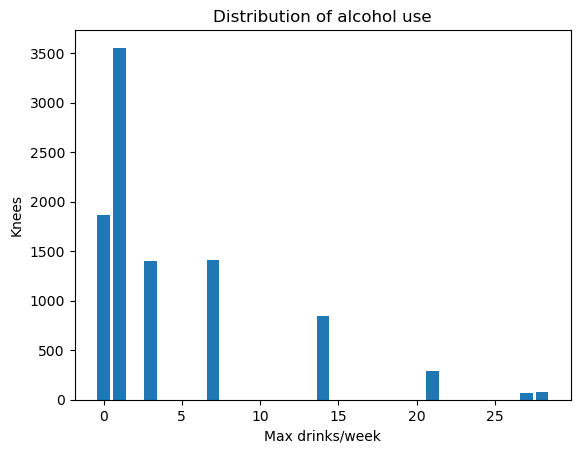

In [66]:
maxdrink_counts = MaxDrinksWk.value_counts()
plt.bar(maxdrink_counts.index, maxdrink_counts)
plt.xlabel("Max drinks/week")
plt.ylabel("Knees")
plt.title("Distribution of alcohol use")

In [67]:
oai['MaxDrinksWk'] = MaxDrinksWk
add_meta('MaxDrinksWk', parent='V00DRNKAMT', var_type='numeric', short_label='Max drinks/week',
        long_label="Maximum alcoholic drinks in typical week")
oai = oai.drop("V00DRNKAMT", axis=1)

### Chair stand variables
* `V00CSTSGL`: Single chair stand
* `V00CS5`: 5 chair stands
* `V00CSPACE`: pace for those who completed 5 chair stands

In [68]:
def castable_to_numeric(arr):
    # Deal with nans: they are castable to numeric, so send them to a number e.g. 0.
    arr_nona = arr.fillna(0)
    
    # Try to cast array to numeric
    nums = pd.to_numeric(arr_nona, errors='coerce')
    
    # Now, anything that is nan is something that cannot be cast to numeric,
    # and everything that can be cast to numeric is a float. So send these floats to 0 and fill the NAs with 1s
    not_numeric = (nums * 0).fillna(1).astype(bool)
    
    # Now flip the booleans.
    return ~not_numeric

In [69]:
cspace2 = oai['V00CSPACE'].mask(castable_to_numeric(oai['V00CSPACE']), 'number')
pd.concat([oai[['V00CS5','V00CSTSGL']], cspace2], axis=1).value_counts().to_frame().sort_index()

0
V00CS5 V00CSTSGL                     V00CSPACE      
0: No  1: Stands without using arms  A           176
       2: Stands using arms          A           168
       3: Attempted, unable to stand A            72
       4: Not attempted, unable      A            38
1: Yes 1: Stands without using arms  number     9108
O      O                             O             2
R      1: Stands without using arms  R            16
       R                             R            12

So, we see that `V00CSPACE` is a child of `V00CS5`--people who successfully did 5 chair stands got a numeric pace, those who did not got an "A" code. (A few got an "R" code). I recommend we code the pace as 0 for anyone who was not able to do 5 chair stands, and then only keep the pace variable.

Text(0.5, 0, 'Pace (stands/sec)')

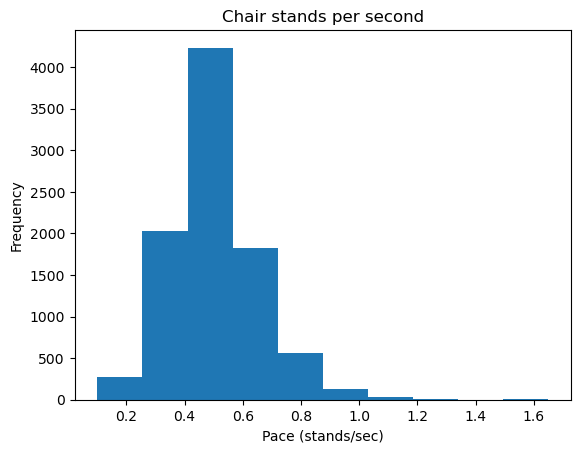

In [70]:
(pd.to_numeric(oai['V00CSPACE'],errors='coerce')).plot.hist()
plt.title("Chair stands per second");
plt.xlabel("Pace (stands/sec)")

In [71]:
oai['V00CSPACE'] = pd.to_numeric(oai['V00CSPACE'],errors='coerce')
oai.loc[oai['V00CS5']=="0: No", 'V00CSPACE'] = 0.0  

In [72]:
oai = oai.drop(['V00CSTSGL', 'V00CS5'], axis=1)

<AxesSubplot:ylabel='Frequency'>

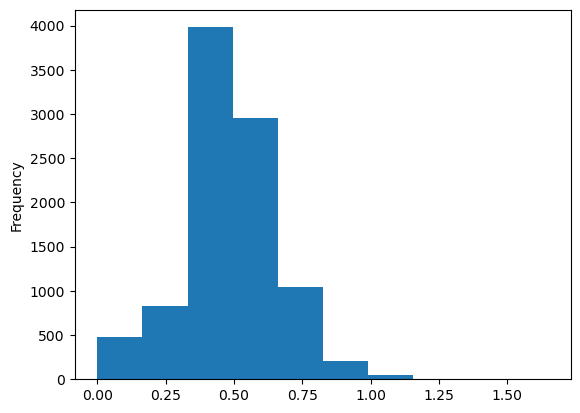

In [73]:
oai['V00CSPACE'].plot.hist()

### `V00EXP1CV` and `V00FXP1CV`: Extension/Flexion pain levels

The following contingency table shows that the flexion pain is not always the same level as the extension pain, so we should probably keep both. 

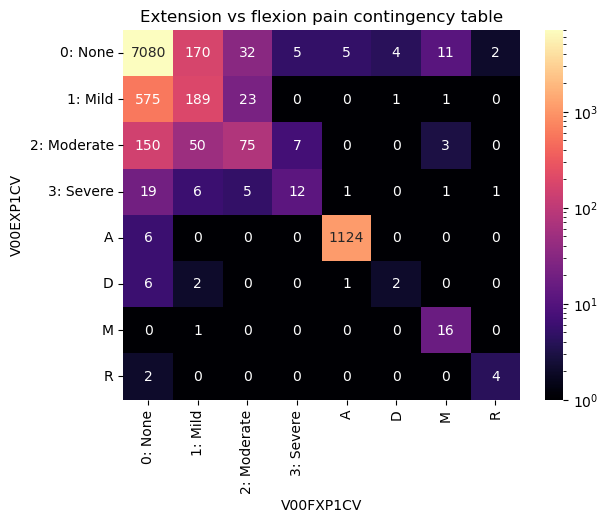

In [74]:
sns.heatmap(
    oai[['V00EXP1CV','V00FXP1CV']].value_counts().unstack(fill_value=0), 
    cmap='magma', norm=LogNorm(clip=True),
    annot=True, fmt="d")
plt.title("Extension vs flexion pain contingency table");

11% of knees have the extension measure different from the flexion measure.

In [75]:
# We're going to collapse Severe into Moderate.
extend_flex_dict = { '0: None':     '0',
                     '1: Mild':     '1',
                     '2: Moderate': '2',
                     '3: Severe':   '2'}
oai['V00EXP1CV'] = oai['V00EXP1CV'].map(extend_flex_dict).fillna(oai['V00EXP1CV'])
oai['V00FXP1CV'] = oai['V00FXP1CV'].map(extend_flex_dict).fillna(oai['V00FXP1CV'])

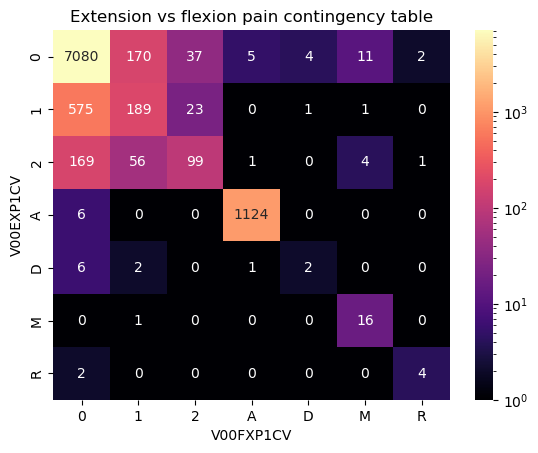

In [76]:
sns.heatmap(
    oai[['V00EXP1CV','V00FXP1CV']].value_counts().unstack(fill_value=0), 
    cmap='magma', norm=LogNorm(clip=True),
    annot=True, fmt="d")
plt.title("Extension vs flexion pain contingency table");

### `V00EDCV`: Education level
We code this as 0, 1, 2, 3, 4, 5. At a later step it will be standardized so that the 0-5 scale doesn't exert outsize influence.

In [77]:
oai['V00EDCV'].value_counts()

5: Graduate degree                   2872
2: Some college                      2292
3: College graduate                  2002
1: High school graduate              1214
4: Some graduate school               794
0: Less than high school graduate     336
R                                      72
M                                      10
Name: V00EDCV, dtype: int64

In [78]:
oai['V00EDCV'] = oai['V00EDCV'].map({'0: Less than high school graduate': 0,
                                     '1: High school graduate': 1, 
                                     '2: Some college': 2, 
                                     '3: College graduate': 3,
                                     '4: Some graduate school': 4, 
                                     '5: Graduate degree': 5})
oai['V00EDCV'].value_counts()

5.0    2872
2.0    2292
3.0    2002
1.0    1214
4.0     794
0.0     336
Name: V00EDCV, dtype: int64

### `V00KEFFPT`

In [79]:
oai['V00KEFFPT'].value_counts()

0: No                       8839
1: Yes                       455
E                            182
A                             68
2: Too tender to examine      21
D                             14
O                             10
R                              2
M                              1
Name: V00KEFFPT, dtype: int64

Only 21 knees have level 2, so we examine them. Can we merge it with level 1?

In [80]:
oai.loc[oai['V00KEFFPT']=="2: Too tender to examine", :]

,ID,P02HISP,side,P01KPN12,P01BP30,P01HPR12CV,P01HPL12CV,V00HSPSS,V00HSMSS,V00WOMKP,V00KOOSKP,V00WOMSTF,V00KOOSYM,V00WOMADL,P01KSX,P01INJ,P01KSURG,V00BONEFX,V00HIPFX,V00SPNFX,V00FALL,V00SMOKE,V00DRKMORE,V00COMORB,V00CESD,V00RXANALG,V00RXNARC,V00RXISTRD,V00RXCOX2,V00RXNSAID,V00BPSYS,V00BPDIAS,V00KPATPN,V00KEFFB,V00KEFFPT,V00KRFXPN,V00KLTTPN,V00KMTTPN,V00KABPN,V00KPFCRE,V00KPGDPN,V00LWGT,P01BMI,V00CSPACE,V00EXP1CV,V00FXP1CV,V0020MPACE,V00KFHDEG,V00KALNMT,V00fmaxf,V00400MTIM,V00fSFR,V00eSFP,V00eSFR,V00fSFP,P02FAMHXKR,V00AGE,V00CUREMP,V00EDCV,V00MEDINS,V00PASE,V00RX30NUM,P01MEN,P01MENINJ,P01ART,P01ARTINJ,P01LR,LowIncome,Other race,White race,Black race,Asian race,Is Married,Female Sex,SameSideHRS,OppositeHRS,BothHRS,SameSideHP12,OppositeHP12,BothHP12,MaxDrinksWk
1705,9207905,0: No,left,1: Yes,1: Yes,1: Yes,0: No,41.89,50.04,4.0,69.4,2.0,57.1,19.0,2.0,0: No,0: No,0: No,0.0,0: No,1: Yes,1: Yes,1: Yes,0,4,1: Used in last 30 days,1: Used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,1: Used in last 30 days,130,84,1: Yes,0: No,2: Too tender to examine,1: Yes,0: No,0: No,0: No,1: Yes,1: Yes,20,26.2,0.44,0,0,1.262,-5,-2,123.7,262.19,137.4,6714,610.4,309.3,1: Yes,48,1: Yes,5.0,1: Yes,264,4,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,1,0.0,0.0,0.0,0.0,1.0,0.0,3.0
2076,9251127,0: No,right,1: Yes,1: Yes,0: No,0: No,51.75,46.44,3.0,86.1,0.0,100.0,2.0,1.0,0: No,0: No,0: No,0.0,0: No,1: Yes,1: Yes,0: No,2,17,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,102,68,1: Yes,D,2: Too tender to examine,0: No,0: No,1: Yes,0: No,0: No,0: No,M,27.6,0.60,A,A,1.598,0,3,A,307.53,A,A,A,A,0: No,59,1: Yes,0.0,1: Yes,207,2,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2346,9278404,0: No,right,1: Yes,0: No,0: No,0: No,23.90,45.47,8.0,65.6,2.0,71.4,22.3,1.0,1: Yes,0: No,0: No,0.0,0: No,1: Yes,1: Yes,1: Yes,3,9,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,136,90,0: No,1: Yes,2: Too tender to examine,1: Yes,0: No,0: No,0: No,0: No,0: No,A,31.7,0.25,A,0,1.004,15,5,A,378.14,A,A,A,A,0: No,62,0: No,2.0,1: Yes,118,2,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2713,9318527,0: No,left,1: Yes,1: Yes,0: No,0: No,48.60,58.89,11.0,40.6,5.0,71.4,21.3,2.0,0: No,0: No,1: Yes,0.0,0: No,0: No,0: No,0: No,1,6,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,128,86,0: No,1: Yes,2: Too tender to examine,1: Yes,1: Yes,1: Yes,1: Yes,R,R,13,23.5,0.40,0,1,1.049,0,-2,86.6,380.81,25,117.2,139,123.7,1: Yes,76,0: No,5.0,1: Yes,172,3,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3398,9392060,0: No,right,1: Yes,1: Yes,1: Yes,0: No,52.50,59.14,3.0,75.0,5.0,57.1,19.1,2.0,0: No,0: No,0: No,0.0,0: No,0: No,1: Yes,0: No,1,2,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,120,74,0: No,0: No,2: Too tender to examine,1: Yes,1: Yes,0: No,0: No,0: No,0: No,16,25.6,0.39,0,0,1.727,6,-3,54.4,250.25,102,244.2,403.8,33,0: No,58,1: Yes,5.0,1: Yes,161,0,0,0,0,0,0,1.0,NaN,NaN,NaN,NaN,0.0,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3422,9394168,0: No,right,1: Yes,0: No,0: No,0: No,25.84,35.53,6.0,58.3,4.0,71.4,29.1,2.0,1: Yes,0: No,1: Yes,0.0,0: No,0: No,0: No,1: Yes,2,42,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,0: Not used in last 30 days,130,80,1: Yes,1: Yes,2: Too tender to examine,0: No,1: Yes,1: Yes,1: Yes,1: Yes,0: No,17,39.5,0.00,0,0,1.009,2,0,32.8,417.97,T,T,T,T,0: No,58,0: No,4.0,1: Yes,27,9,0,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3423,9394168,0: No,left,1: Yes,0: No,0: No,0: No,25.84,35.53,12.0,27.8,8.0,42.9,40.1,2.0,1: Yes,0: No,1: Yes,0.0,0: No,0: No,0: No,1: Yes,2,42,0: Not used in last 

Most of these knees will get dropped because they are missing the income variable. There should be not problem to merge the level 2 with level 1.

In [81]:
oai.loc[oai['V00KEFFPT']=="2: Too tender to examine", 'V00KEFFPT'] = "1: Yes"

data_dict.loc['V00KEFFPT', 'var_type'] = 'binary'

## Arthoscopy, menisectomy, ligament repair

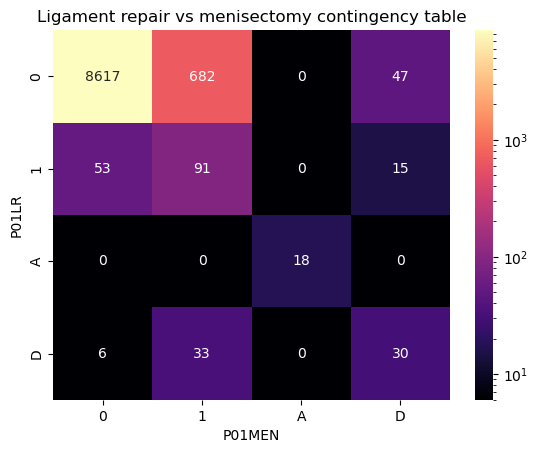

In [82]:
sns.heatmap(
    oai[['P01LR','P01MEN']].value_counts().unstack(fill_value=0), 
    cmap='magma', norm=LogNorm(clip=True),
    annot=True, fmt="d")
plt.title("Ligament repair vs menisectomy contingency table");

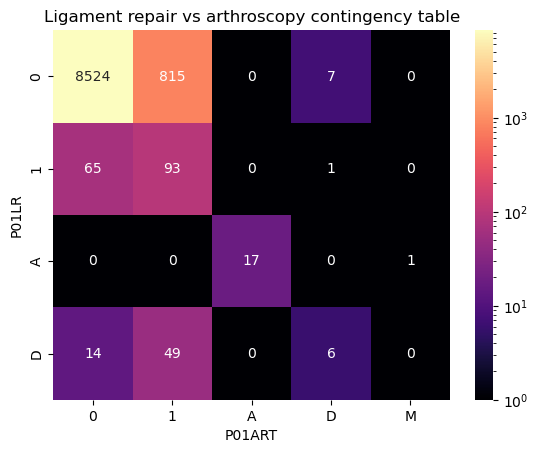

In [83]:
sns.heatmap(
    oai[['P01LR','P01ART']].value_counts().unstack(fill_value=0), 
    cmap='magma', norm=LogNorm(clip=True),
    annot=True, fmt="d")
plt.title("Ligament repair vs arthroscopy contingency table");

If we have `P01ART`, do we also need `P01ARTINJ`? The latter is only 1 if the former is 1

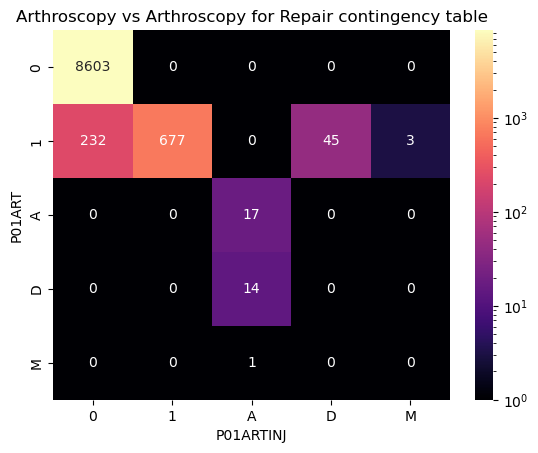

In [84]:
sns.heatmap(
    oai[['P01ART','P01ARTINJ']].value_counts().unstack(fill_value=0), 
    cmap='magma', norm=LogNorm(clip=True),
    annot=True, fmt="d")
plt.title("Arthroscopy vs Arthroscopy for Repair contingency table");

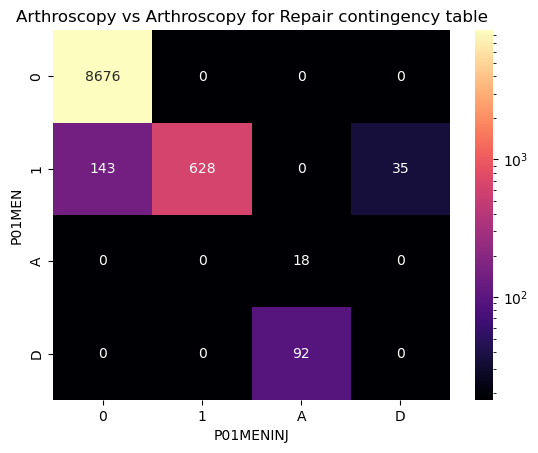

In [85]:
sns.heatmap(
    oai[['P01MEN','P01MENINJ']].value_counts().unstack(fill_value=0), 
    cmap='magma', norm=LogNorm(clip=True),
    annot=True, fmt="d")
plt.title("Arthroscopy vs Arthroscopy for Repair contingency table");

We've decided to drop the `P01MENINJ` and `P01ARTINJ` -- we're less interested in whether the surgery was due to an injury.

In [86]:
oai = oai.drop(['P01MENINJ', 'P01ARTINJ'], axis=1)

## RX variables

In [87]:
rx_vars = ["V00RXANALG", "V00RXNARC","V00RXISTRD","V00RXCOX2","V00RXNSAID"]
oai[rx_vars].apply(lambda s: s.value_counts(), axis=0)

,V00RXANALG,V00RXNARC,V00RXISTRD,V00RXCOX2,V00RXNSAID
0: Not used in last 30 days,7252,9098,9560,8780,8644
1: Used in last 30 days,2314,468,6,786,922
M,26,26,26,26,26


In [88]:
for colname in rx_vars:
    oai[colname] = oai[colname].map({"0: Not used in last 30 days": 0,
                                     "1: Used in last 30 days":     1})
oai[rx_vars].apply(lambda s: s.value_counts(), axis=0)

,V00RXANALG,V00RXNARC,V00RXISTRD,V00RXCOX2,V00RXNSAID
0.0,7252,9098,9560,8780,8644
1.0,2314,468,6,786,922


## What data processing remains?

In [89]:
masked = oai.mask(oai.apply(castable_to_numeric, axis=0), 'number').drop(['ID','side'], axis=1)

In [90]:
value_counts_df = masked.apply(lambda s: s.value_counts(), axis=0).fillna(0).T

In [91]:
value_counts_df = value_counts_df[value_counts_df['number'] < 9592]

In [92]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
value_counts_df

,0: No,1: Yes,A,C,D,E,I,K,L,M,O,R,T,W,number
P02HISP,9468.0,120.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
P01KPN12,2745.0,6835.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P01BP30,4002.0,5584.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P01HPR12CV,7904.0,1662.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P01HPL12CV,8008.0,1548.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V00HSPSS,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,6.0,0.0,68.0,0.0,0.0,9468.0
V00HSMSS,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,6.0,0.0,68.0,0.0,0.0,9468.0
V00WOMKP,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9589.0
V00KOOSKP,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9587.0
V00WOMSTF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,9586.0


What remains now is to map the 0: no and 1: yes to 0.1 and check that we're ok with the As.

In [93]:
A_df = (oai=='A')
Acols = A_df.any(axis=0)
A_df = A_df.loc[:, Acols].astype(int)

In [94]:
matching_As = A_df.T @ A_df

<Figure size 900x900 with 0 Axes>

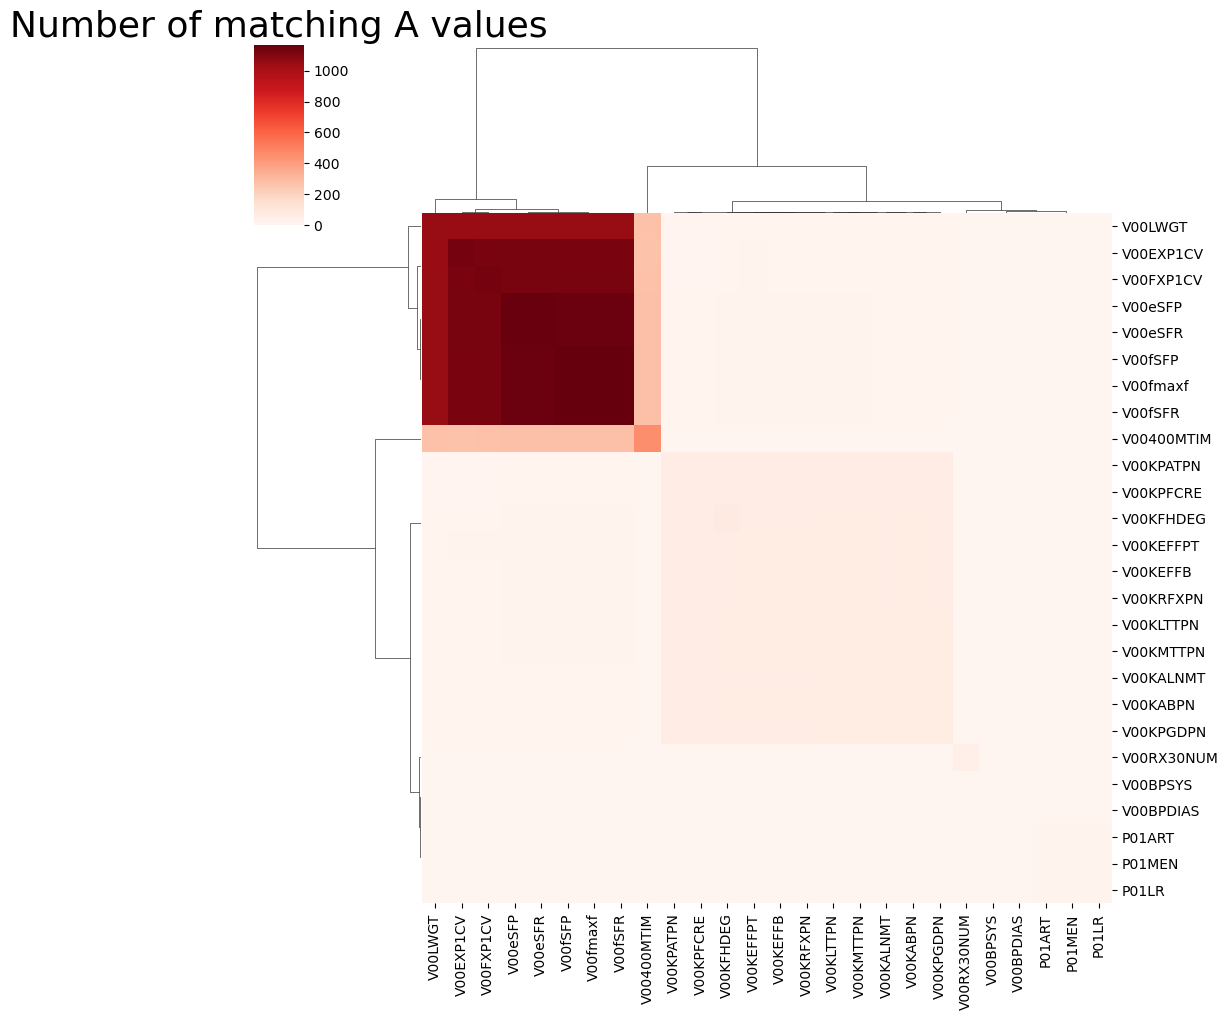

In [95]:
plt.figure(figsize=(9,9))
sns.clustermap(matching_As, cmap='Reds')
plt.title("Number of matching A values", fontsize=26)
plt.show()

OK, so mainly the As are from people who didn't have the force measurements done. We'll have to drop them, and so we can send all As to nan.

In [96]:
binaries_to_clean = value_counts_df.loc[(value_counts_df['0: No'] > 0) & (value_counts_df['1: Yes'] > 0)].index
binaries_to_clean

Index(['P02HISP', 'P01KPN12', 'P01BP30', 'P01HPR12CV', 'P01HPL12CV', 'P01INJ',
       'P01KSURG', 'V00BONEFX', 'V00SPNFX', 'V00FALL', 'V00SMOKE',
       'V00DRKMORE', 'V00KPATPN', 'V00KEFFB', 'V00KEFFPT', 'V00KRFXPN',
       'V00KLTTPN', 'V00KMTTPN', 'V00KABPN', 'V00KPFCRE', 'V00KPGDPN',
       'P02FAMHXKR', 'V00CUREMP', 'V00MEDINS'],
      dtype='object')

In [97]:
for colname in binaries_to_clean:
    oai[colname] = oai[colname].map({'0: No': 0, '1: Yes': 1})

In [98]:
oai.head(50)

,ID,P02HISP,side,P01KPN12,P01BP30,P01HPR12CV,P01HPL12CV,V00HSPSS,V00HSMSS,V00WOMKP,V00KOOSKP,V00WOMSTF,V00KOOSYM,V00WOMADL,P01KSX,P01INJ,P01KSURG,V00BONEFX,V00HIPFX,V00SPNFX,V00FALL,V00SMOKE,V00DRKMORE,V00COMORB,V00CESD,V00RXANALG,V00RXNARC,V00RXISTRD,V00RXCOX2,V00RXNSAID,V00BPSYS,V00BPDIAS,V00KPATPN,V00KEFFB,V00KEFFPT,V00KRFXPN,V00KLTTPN,V00KMTTPN,V00KABPN,V00KPFCRE,V00KPGDPN,V00LWGT,P01BMI,V00CSPACE,V00EXP1CV,V00FXP1CV,V0020MPACE,V00KFHDEG,V00KALNMT,V00fmaxf,V00400MTIM,V00fSFR,V00eSFP,V00eSFR,V00fSFP,P02FAMHXKR,V00AGE,V00CUREMP,V00EDCV,V00MEDINS,V00PASE,V00RX30NUM,P01MEN,P01ART,P01LR,LowIncome,Other race,White race,Black race,Asian race,Is Married,Female Sex,SameSideHRS,OppositeHRS,BothHRS,SameSideHP12,OppositeHP12,BothHP12,MaxDrinksWk
0,9000099,0.0,right,1.0,1.0,0.0,0.0,52.50,59.60,1.0,77.8,3.0,67.9,10.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0.0,0.0,0.0,0.0,0.0,124,60,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23,23.8,0.00,1,0,1.328,10,3,160.5,309.03,437.7,86.4,1243.6,63.4,0.0,59,1.0,5.0,1.0,132,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
1,9000099,0.0,left,1.0,1.0,0.0,0.0,52.50,59.60,0.0,100.0,0.0,100.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0.0,0.0,0.0,0.0,0.0,124,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,22,23.8,0.00,0,0,1.328,8,-4,140.9,309.03,704.5,362.3,1425.2,31,0.0,59,1.0,5.0,1.0,132,0,1,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
2,9000296,0.0,right,0.0,0.0,1.0,0.0,56.15,57.16,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,2,1.0,0.0,0.0,1.0,0.0,152,84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,29.8,0.48,0,0,1.366,3,0,197.5,313.71,103,611.4,280.5,359.1,0.0,69,1.0,2.0,1.0,190,3,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
3,9000296,0.0,left,0.0,0.0,1.0,0.0,56.15,57.16,0.0,100.0,0.0,100.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,2,1.0,0.0,0.0,1.0,0.0,152,84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,29.8,0.48,0,0,1.366,3,-2,225.6,313.71,966.9,322.1,563.7,270.7,0.0,69,1.0,2.0,1.0,190,3,1,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
4,9000622,0.0,right,1.0,1.0,1.0,0.0,33.23,65.54,3.0,75.0,3.0,82.1,14.9,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1,4,0.0,0.0,0.0,0.0,0.0,136,60,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14,22.7,0.60,0,0,1.431,0,3,75.6,295.91,453.6,497.3,113.5,19,0.0,71,0.0,1.0,0.0,157,8,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,1,0.0,0.0,0.0,1.0,0.0,0.0,3.0
5,9000622,0.0,left,0.0,1.0,1.0,0.0,33.23,65.54,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1,4,0.0,0.0,0.0,0.0,0.0,136,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,22.7,0.60,0,0,1.431,-5,0,67.9,295.91,21.4,536.7,184.5,27.5,0.0,71,0.0,1.0,0.0,157,8,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,1.0,0.0,3.0
6,9000798,0.0,right,0.0,0.0,0.0,0.0,46.03,55.51,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,12,0.0,0.0,0.0,0.0,0.0,120,86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,24,32.4,0.34,0,0,1.064,1,-6,150.4,383.25,58.6,521.5,147.7,130.8,1.0,56,1.0,2.0,1.0,250,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
7,9000798,0.0,left,1.0,0.0,0.0,0.0,46.03,55.51,8.0,59.4,5.0,57.1,17.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,12,0.0,0.0,0.0,0.0,0.0,120,86,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,22,32.4,0.34,0,0,1.064,3,-4,163.9,383.25,44.9,380.9,577.5,234.1,1.0,56,1.0,2.0,1.0,250,0,0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
8,9001104,0.0,right,1.0,1.0,0.0,0.0,49.68,59.29,4.0,69.4,4.0,60.7,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0.0,0.0,0.0,0.0,0.0,112,84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,30.7,0.56,0,0,1.392,0,0,82.8,341.00,41.7,403.8,109.7,75.3,1.0,72,0.0,2.0,0.0,164,5,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,9001104,0.0,left,0.0,1.0,0.0,0.0,49.68,59.29,0.0,100.0,4.0,85.7,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0.0,0.0,0.0,0.0,0.0,112,84,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15,30.7,0.56,0,0,1.392,0,3,79.8,341.00,106.4,87,594.2,97.7,1.0,72,0.0,2.0,0.0,164,5,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [99]:
temp = oai.mask(oai.apply(castable_to_numeric, axis=0), 'number').drop(['ID', 'side'], axis=1)
temp = temp.apply(lambda s: s.value_counts(), axis=0).fillna(0).T

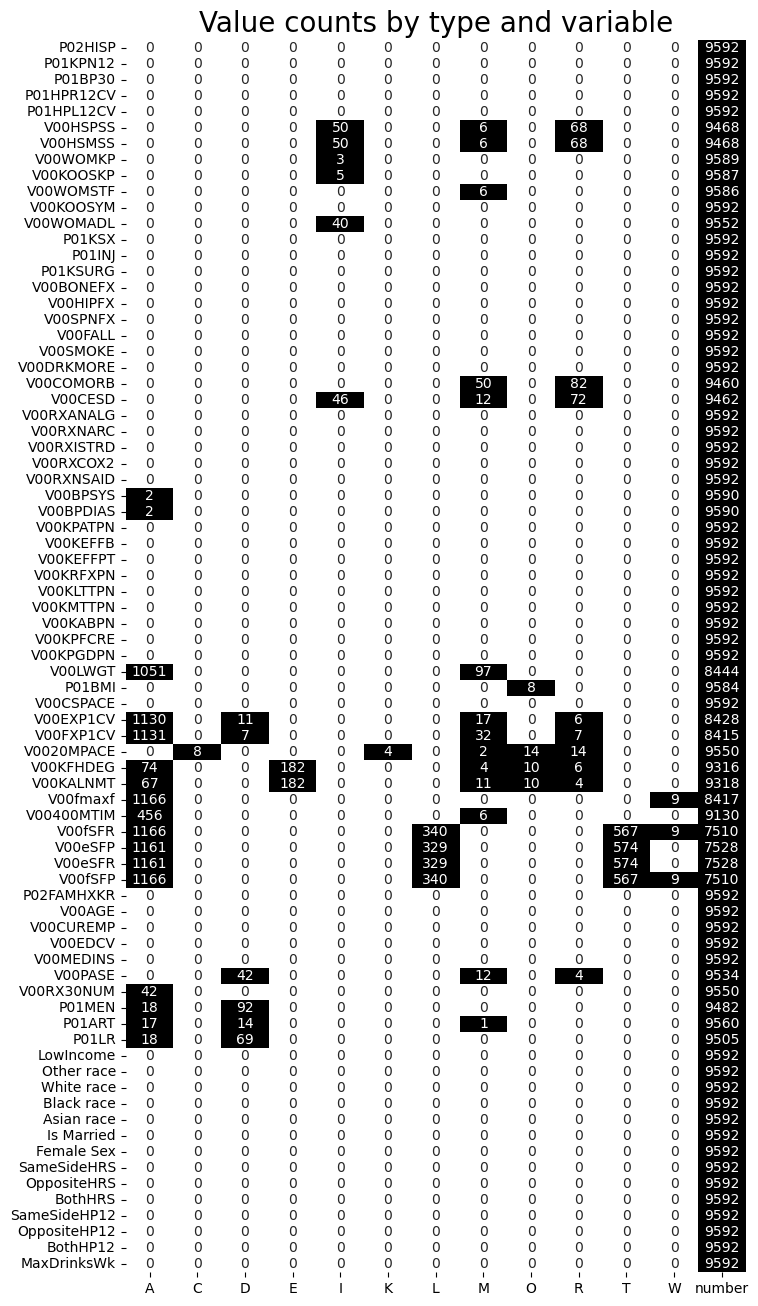

In [100]:
plt.figure(figsize=(8,16))
sns.heatmap(temp, vmin=0, vmax=1, cmap='Greys', annot=True, fmt='.0f', cbar=False)
plt.title("Value counts by type and variable", fontsize=20);

# Final checks

Coerce all variables to numeric:

In [101]:
for colname in oai.drop(['ID','side'], axis=1).columns:
    oai[colname] = pd.to_numeric(oai[colname], errors='coerce')

Drop missings:

In [102]:
oai = oai.dropna(axis=0)

Final data shape?

In [103]:
oai.shape

(6317, 79)

# Convert to Xarray so that we can save as Zarr store

In [105]:
oai_xr = oai.rename({"ID": "patient_id"}, axis=1).to_xarray()
oai_xr

<xarray.Dataset>
Dimensions:       (index: 6317)
Coordinates:
  * index         (index) int64 0 1 2 3 4 5 6 ... 9582 9583 9588 9589 9590 9591
Data variables: (12/79)
    patient_id    (index) int64 9000099 9000099 9000296 ... 9999878 9999878
    P02HISP       (index) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    side          (index) object 'right' 'left' 'right' ... 'right' 'left'
    P01KPN12      (index) float64 1.0 1.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    P01BP30       (index) float64 1.0 1.0 0.0 0.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    P01HPR12CV    (index) float64 0.0 0.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    ...            ...
    OppositeHRS   (index) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    BothHRS       (index) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SameSideHP12  (index) float64 0.0 0.0 1.0 0.0 1.0 ... 0.0 1.0 0.0 0.0 0.0
    OppositeHP12  (index) float64 0.0 0.0 0.0 1.0 0.0 ... 0.0 0.0 1.0 0.0 0.0
    BothHP12      (index) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MaxDrinksWk   (index) float64 14.0 14.0 3.0 3.0 3.0 ... 0.0 1.0 1.0 3.0 3.0

In [106]:
oai_xr = (oai_xr.set_coords(["patient_id","side"])
                .rename_dims({"index": "knee"})
                .drop_vars("index")
         )
oai_xr

<xarray.Dataset>
Dimensions:       (knee: 6317)
Coordinates:
    patient_id    (knee) int64 9000099 9000099 9000296 ... 9999878 9999878
    side          (knee) object 'right' 'left' 'right' ... 'left' 'right' 'left'
Dimensions without coordinates: knee
Data variables: (12/77)
    P02HISP       (knee) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    P01KPN12      (knee) float64 1.0 1.0 0.0 0.0 1.0 0.0 ... 1.0 0.0 0.0 0.0 0.0
    P01BP30       (knee) float64 1.0 1.0 0.0 0.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    P01HPR12CV    (knee) float64 0.0 0.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    P01HPL12CV    (knee) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    V00HSPSS      (knee) float64 52.5 52.5 56.15 56.15 ... 54.26 52.91 52.91
    ...            ...
    OppositeHRS   (knee) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    BothHRS       (knee) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SameSideHP12  (knee) float64 0.0 0.0 1.0 0.0 1.0 0.0 ... 0.0 1.0 0.0 0.0 0.0
    OppositeHP12  (knee) float64 0.0 0.0 0.0 1.0 0.0 1.0 ... 0.0 0.0 1.0 0.0 0.0
    BothHP12      (knee) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MaxDrinksWk   (knee) float64 14.0 14.0 3.0 3.0 3.0 ... 0.0 1.0 1.0 3.0 3.0

### Set the metadata

In [106]:
for name, data_array in oai_xr.data_vars.items():
    oai_xr[name] = data_array.assign_attrs(data_dict.loc[name].dropna())

In [107]:
oai_xr['P02HISP']

<xarray.DataArray 'P02HISP' (knee: 6317)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
    index       (knee) int64 0 1 2 3 4 5 6 ... 9582 9583 9588 9589 9590 9591
    patient_id  (knee) int64 9000099 9000099 9000296 ... 9999865 9999878 9999878
    side        (knee) object 'right' 'left' 'right' ... 'left' 'right' 'left'
Dimensions without coordinates: knee
Attributes:
    column_number:  2
    var_type:       binary
    short_label:    Is Hispanic
    long_label:     IEI:Q3.Hispanic or Latino, self-reported
    format:         YNDK

# Save as Zarr store

In [112]:
# Zarr is picky about the encoding of strings.
# https://github.com/pydata/xarray/issues/3476
oai_xr.coords['side'] = oai_xr.coords['side'].astype("unicode")

In [113]:
oai_xr.to_zarr("processed_data/processed_oai_clinical.zarr");